# Entrenamiento de W2V usando Keras

Para entrenar W2V itilizando Keras seguiremos los siguientes pasos:

1- Cargamos un dataset de artículos periodísticos.  
2- Obtenemos el vocabulario a partir de las $num\_words$ palabras que mas aparezcan.  
3- Convertimos cada uno de los artículos en un vector de índices que representan a cada una de las palabras.  
4_ A partr de los vectores de índices generamos samples positivos anotados con un "1" y samples negativos anotados con un "0".  
5_ Armamos la red neuronal vista en la teoría y entrenamos con los pares generados en el punto anterior.  
6_ Extraemos las matrices de embeddings de target y context de la red entrenada y las sumamos.  
7_ Evaluamos los embeddings obtenidos corriendo una lista de tests de analogía.

# 1- Carga de artículos periodísticos

Cargamos los artículos de train del Twenty News Groups y visualizamos el primer artículo para ver su formato.

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







# 2- Obtenemos el vocabulario a partir de las  $num\_words$  palabras que mas aparezcan.

In [2]:
num_words=30000 #defino la cantidad de palabras del vocabulario
from keras.preprocessing.text import Tokenizer
token_TNG=Tokenizer(num_words=num_words, #Cantidad de palabras en el vocabulario 
                    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # Caracteres que se eliminan del texto  antes de procesar
                    lower=True,       # Si lower=true, se pasa el texto a minúsculas
                    split=' ',        # Caracter que delimita las palabras en el texto. Típicamente es un espacio.
                    char_level=False, # Si char_level=True, todos los caracteres son tratados como tokens distintos
                    oov_token="UNK")  # Token en el que se computaran las ocurrencias de palabras que estén fuera del vocabulario

Using TensorFlow backend.


In [0]:
token_TNG.fit_on_texts(newsgroups_train.data) # Calculamos el vocabulario en base a los textos proporcionados

In [4]:
token_TNG.index_word # Este diccionario nos dice qué palabra tiene asociado cada número de índice. Veamos las primeras cinco palabras.
for idx in range(1,10):
  print(idx, token_TNG.index_word[idx])

1 UNK
2 the
3 to
4 of
5 a
6 'ax
7 and
8 in
9 i


In [5]:
token_TNG.word_index # Este diccionario nos dice qué número de índice tiene asociada cada palabra. Veamos las primeras cinco palabras
for idx, (key,value) in enumerate(token_TNG.word_index.items()):
  print(key,value)
  if idx == 10:
    break;

UNK 1
the 2
to 3
of 4
a 5
'ax 6
and 7
in 8
i 9
is 10
that 11


Por curiosidad, podemos verificar que el vocabulario siga una distribución Zipf.

In [6]:
token_TNG.word_counts # Esta lista contiene tuplas con (palabra, cantidad de ocurrencias)
for idx,pair in enumerate(token_TNG.word_counts.items()):
  print(pair)
  if idx==10:
    break

('from', 22668)
('lerxst', 4)
('wam', 81)
('umd', 295)
('edu', 21228)
("where's", 23)
('my', 9728)
('thing', 1527)
('subject', 12261)
('what', 9375)
('car', 1297)


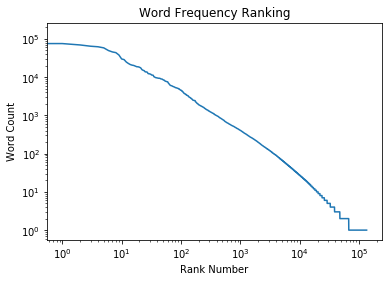

In [7]:
# Ordenamos los valores de cuenta de menor a mayor y lo graficamos
import numpy as np
from matplotlib import pyplot as plt
ordered_count=np.sort(np.array(list(token_TNG.word_counts.values())))[::-1]
plt.loglog(ordered_count)
plt.title("Word Frequency Ranking")
plt.ylabel("Word Count")
plt.xlabel("Rank Number")
plt.show()

## 3- Convertimos cada uno de los artículos en un vector de índices que representan a cada una de las palabras.

Para ello usamos el método .texts_to_sequences del tokenizador.

In [0]:
sequences_train=token_TNG.texts_to_sequences(newsgroups_train.data)

Veamos cómo quedaron las diez primeras palabras del primer artículo convertido a índices.

In [9]:
sequences_train[0][0:10]

[15, 1, 4309, 1351, 16, 11127, 39, 251, 30, 43]

## 4_ A partr de los vectores de índices generamos samples positivos anotados con un "1" y samples negativos anotados con un "0".

Para ello Word2Vec maneja dos parámetros:

- La probabilidad de quedarnos con los positive samples de cada palabra que aparece en el texto.
- La proporción entre positive samples tomados del texto y la cantidad de negative samples generados

La probabilidad de quedarnos con los positive samples de cada palabra que aparece en el texto, los podemos obtener utilizando la función make_sampling_table de Keras, la cual recibe el tamaño del vocabulario y sampling_factor.

In [0]:
# Generemos la tabla que nos dirá con qué probabilidad samplearemos a cada una de las palabras, dependiendo de su frecuencia de aparición.


from keras.preprocessing.sequence import make_sampling_table
#Generamos las tablas de sampleo
sampling_table1=make_sampling_table(num_words, sampling_factor=1e-04)
sampling_table2=make_sampling_table(num_words, sampling_factor=1e-05)
sampling_table3=make_sampling_table(num_words, sampling_factor=1e-06)

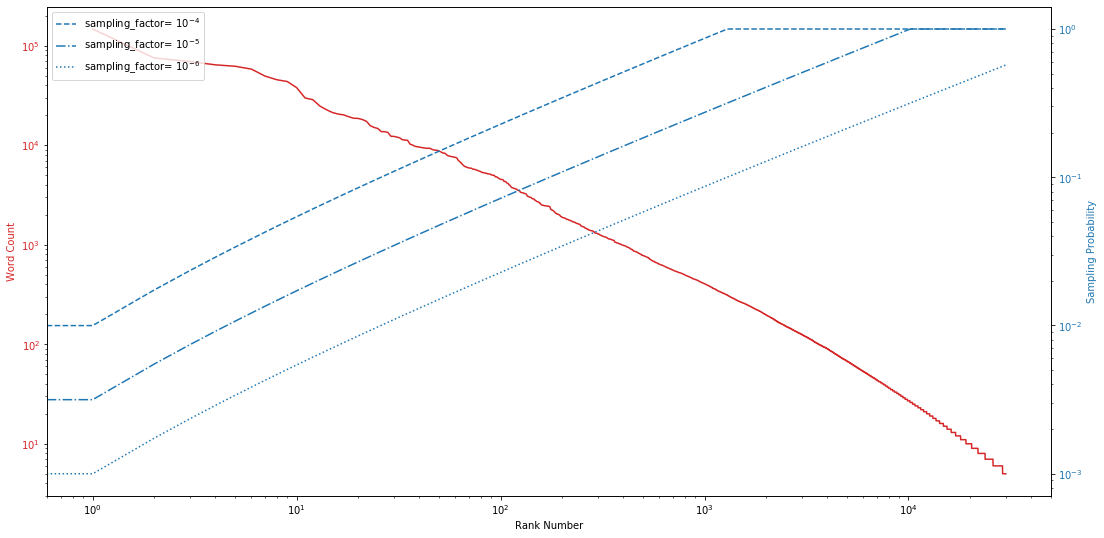

In [11]:
# Superpongamos la probabilidad de sampleo de cada palabra con su probabilidad de ocurrencia

fig, ax1 = plt.subplots(figsize=[18,9])

color = 'tab:red'
ax1.set_xlabel("Rank Number")
ax1.set_ylabel('Word Count', color=color)
ax1.loglog(range(1,num_words+1),ordered_count[0:num_words],c=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Sampling Probability', color=color)  # we already handled the x-label with ax1
ax2.loglog(sampling_table1,'--',label="sampling_factor= $10^{-4}$",c=color)
ax2.loglog(sampling_table2,'-.',label="sampling_factor= $10^{-5}$",c=color)
ax2.loglog(sampling_table3,':',label="sampling_factor= $10^{-6}$",c=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.show()

Con la tabla de sampleo generada podemos obtener los pares utilizando la función skipgram de keras.

En principio, transformemos un solo artículo para ver qué nos devuelve. Correr las siguientes celdas varias veces para verificar que el sampling que se hace es siempre distinto.

In [0]:
from keras.preprocessing.sequence import skipgrams
pairs,labels=skipgrams(sequences_train[0],  # sequencia a Samplear
          num_words, # Cantidad de palabras en el vocabulario
          window_size=4, # Tamaño de la ventana de contexto
          negative_samples=0.75, # Proporción de negative samples con respecto a los positive samples
          shuffle=False, # Mezcla los samples luego de obtenerlos
          sampling_table=sampling_table2) #Probabilidad de quedarse con la palabra cuando aparece en el texto

Recordemos los primeros valores de la secuencia

In [13]:
sequences_train[0][0:15]

[15, 1, 4309, 1351, 16, 11127, 39, 251, 30, 43, 299, 10, 18, 96, 79]

In [14]:
# Veamos los primeros samples si corresponden con la secuencia, y cómo son sus labels
pairs[0:15]

[[4309, 15],
 [4309, 1],
 [4309, 1351],
 [4309, 16],
 [4309, 11127],
 [4309, 39],
 [11127, 1],
 [11127, 4309],
 [11127, 1351],
 [11127, 16],
 [11127, 39],
 [11127, 251],
 [11127, 30],
 [11127, 43],
 [23734, 18]]

In [15]:
labels[0:15]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [16]:
# los últimos samples de la lista de pares son samples negativos, que se generan en forma aleatoria
pairs[-1:-15:-1]

[[9880, 18368],
 [2953, 22808],
 [1498, 7519],
 [1163, 29980],
 [124, 29746],
 [4309, 29868],
 [1163, 6107],
 [2953, 13003],
 [4309, 15528],
 [8165, 20519],
 [299, 20014],
 [23734, 5117],
 [4018, 28162],
 [21901, 26237]]

In [17]:
labels[-1:-15:-1]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Verifiquemos la proporción que hay entre positive samples y negative samples.

In [18]:
sum(np.array(labels)==0)/sum(np.array(labels)==1)

0.7457627118644068

Si bien no es del todo correcto, se suelen hacer un join de todas las secuencias y se pasa a skipgrams como si fuera una secuencia sola.

In [0]:
joint_seqs=list()
for sequence in sequences_train:
  joint_seqs += sequence

In [20]:
# Cantidad de tokens
len(joint_seqs)

3663183

In [0]:
pairs,labels=skipgrams(joint_seqs,  # sequencia a Samplear
          num_words, # Cantidad de palabras en el vocabulario
          window_size=5, # Tamaño de la ventana de contexto
          negative_samples=0.75, # Proporción de negative samples con respecto a los positive samples
          shuffle=False, # Mezcla los samples luego de obtenerlos
          sampling_table=sampling_table2) #Probabilidad de quedarse con la palabra cuando aparece en el texto

In [22]:
# Cantidad de pares
len(pairs)

15045017

In [23]:
# Cantidad de labels
len(labels)

15045017

## 5_ Armamos la red neuronal vista en la teoría y entrenamos con los pares generados en el punto anterior.

In [24]:
from keras.layers import Embedding, Dot, Input,Reshape, Dot, Activation
from keras.models import Model
d=300

input_target = Input(shape=(1,), dtype='int32')
input_context = Input(shape=(1,), dtype='int32')

target_embedding = Embedding(num_words, d, input_length=1, name='t_embedding')
context_embedding = Embedding(num_words, d, input_length=1, name='c_embedding')
target = target_embedding(input_target)
target = Reshape((d, 1))(target)
context = context_embedding(input_context)
context = Reshape((d, 1))(context)

# now perform the dot product operation to get a similarity measure
dot_product = Dot(axes=1)([target, context])
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Activation("sigmoid")(dot_product)

In [25]:
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='Adam')
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
t_embedding (Embedding)         (None, 1, 300)       9000000     input_1[0][0]                    
__________________________________________________________________________________________________
c_embedding (Embedding)         (None, 1, 300)       9000000     input_2[0][0]                 

In [0]:
targets=np.array(pairs)[:,0]
contexts=np.array(pairs)[:,1]

In [27]:
model.fit([targets, contexts],labels,verbose=1,epochs=3, batch_size=8192)




Epoch 1/3





15045017/15045017 [==============================] - 75s 5us/step - loss: 0.3666
Epoch 2/3
15045017/15045017 [==============================] - 69s 5us/step - loss: 0.2603
Epoch 3/3
15045017/15045017 [==============================] - 69s 5us/step - loss: 0.2100


## 6_ Extraemos las matrices de embeddings de target y context de la red entrenada y las sumamos.

In [0]:
embeddings=target_embedding.get_weights()[0] + context_embedding.get_weights()[0]
embeddings=context_embedding.get_weights()[0]

Veamos cómo quedan los embeddings de algunas palabras

In [0]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(2, 0.4, metric="cosine")

In [67]:
neigh.fit(embeddings)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                 radius=0.4)

In [0]:
def print_neighbors(w1,rev_dict,N=10):
  neighbors=neigh.kneighbors(embeddings[token_TNG.word_index[w1]].reshape(1, -1), N, return_distance=False)
  for word in neighbors[0]:
    print(rev_dict[word])

In [1]:
print_neighbors("cars",token_TNG.index_word)

NameError: ignored